In [ ]:
!pip install openpyxl==3.0.0

     |████████████████████████████████| 172 kB 5.3 MB/s 
  Created wheel for openpyxl: filename=openpyxl-3.0.0-py2.py3-none-any.whl size=241207 sha256=0f1283e078cdc81c9e0299d1c75c5a109aa4379095839e8d81037d6127e69dc5
  Stored in directory: /root/.cache/pip/wheels/c7/64/ff/ce98f6e1d2701ae8e216c875da62feed2839ac8a3cae0ab8af
Successfully built openpyxl
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


In [ ]:
import tensorflow.keras as K
import tensorflow.keras.backend as BK
import math
from tensorflow.keras.callbacks import LambdaCallback

class LRFinder:
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = BK.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        BK.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = BK.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        BK.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        BK.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = BK.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        BK.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        BK.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.axvline(x=self.get_best_lr(20, 10, 1), color='r', linestyle='-.')

        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

def find_best_lr(x, y, model):
    lrf = LRFinder(model)
    lrf.find(x, y, start_lr=1e-10, end_lr=1e+1, batch_size=512, epochs=6)
    
    lrf.plot_loss()
    return lrf.get_best_lr(20,10,1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rsync --info=progress2 --recursive /content/drive/MyDrive/DataSets/Rezaii/* .

      9,147,603 100%   78.31MB/s    0:00:00 (xfr#7, to-chk=0/8)


In [ ]:
import numpy as np
import pandas as pd
print(np.__version__)
def data2matrix():
    df = pd.read_csv('Task1_P.csv')    
    #remove indexing in features 
    df = df.drop(['ZONEID'], axis=1)
    df = df.drop(['timestamp'], axis=1)

    #produce an numpy array
    df = df.dropna(how='any')  
    return df
def excel2matrix(name):

    col = 18
    if name == '1397': col = 19
    iran = pd.read_excel('{}.xlsx'.format(name), usecols=[col]) 
    
    iran = np.array(iran[4:])
    return iran[iran !=0]


1.19.5


['1397', '1398', '1399']


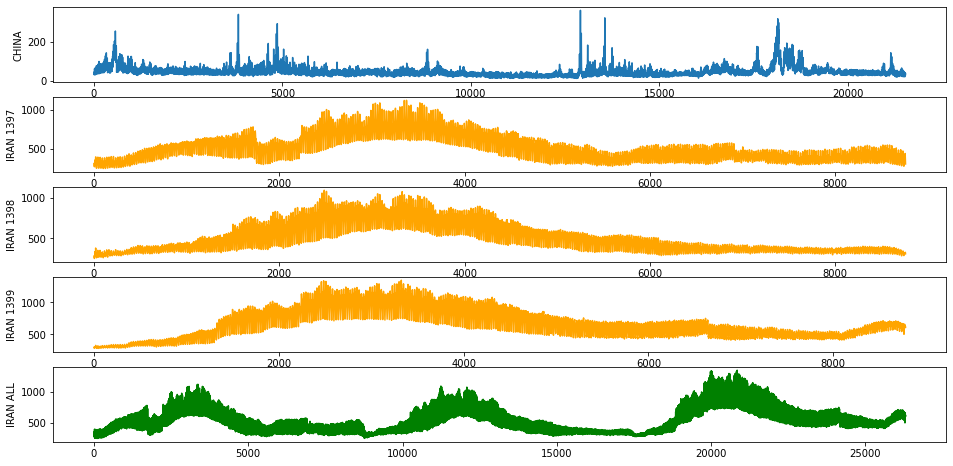

In [ ]:
import matplotlib.pyplot as plt
import os

files = ['1397', '1398', '1399']
fig = plt.figure(figsize=(16,8))
df2=data2matrix()
plt.subplot(len(files)+2,1,1)
plt.plot(df2[['Zonal Price']])
plt.ylabel('CHINA')

print(files)

for i, file in enumerate(files):
  data = excel2matrix(file)
  plt.subplot(len(files)+2,1,i+2)
  plt.plot(data, color = 'orange')
  plt.ylabel('IRAN {}'.format(file))
  if i == 0:
    df = data
  else:
    df = np.concatenate((df, data), axis=0)



plt.subplot(len(files)+2,1,i+3)
plt.plot(df, color = 'green')
plt.ylabel('IRAN ALL')
plt.show()

In [ ]:
from CEEMDAN import CEEMDAN


T= df
T.shape=(len(df),)
T=(T - min(T)) / (max(T) - min(T))
DTYPE = np.float64
T = T.astype(DTYPE)

emd = CEEMDAN()
emd.FIXE_H = 5
emd.nbsym = 2
emd.spline_kind = 'cubic'
emd.DTYPE = DTYPE

imfs = emd.emd(T)

In [ ]:
########Step 3: HIGH-FREQUENCY IMFS NOISE REDUCTION ###############
imfNo = imfs.shape[0]
length=len(imfs[0])
std_ts = np.std(imfs)
landa=std_ts*(np.sqrt((2*np.log(length))/(np.log(imfNo+1))))

imfs_free=[]
for i in range(len(imfs)):
    temp=[]
    for j in range(len(imfs[0])):
        if (np.abs(imfs[i][j]>=landa)):
            temp.append(imfs[i][j]*(imfs[i][j]-landa))
        else:
            temp.append(0)
    imfs_free.append(temp)

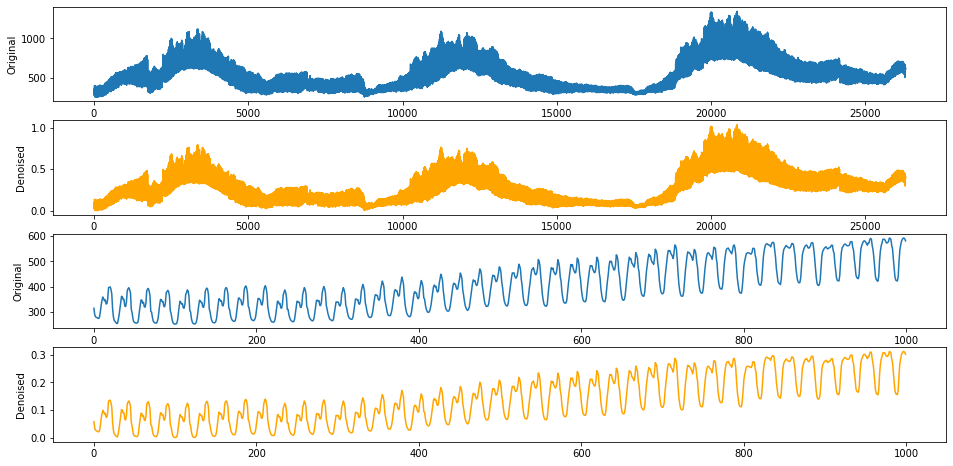

In [ ]:
#########Step 4: RECONSTRUCTION ###############
reconstructed=[]
for i in range(len(imfs[0])):
    sum_IMF_high=0
    sum_IMF_low=0
    for j in range(len(imfs)):
        sum_IMF_high+=imfs[j][i]
        sum_IMF_low+=imfs_free[j][i]
    reconstructed.append(sum_IMF_high+sum_IMF_low)
df1 = df
org = (df1-df1.min())/(df1.max()-df1.min())

fig = plt.figure(figsize=(16,8))

plt.subplot(4,1,1)
plt.plot(df1)
plt.ylabel('Original')

plt.subplot(4,1,2)
plt.plot(reconstructed, color = 'orange')
plt.ylabel('Denoised')

plt.subplot(4,1,3)
plt.plot(df1[:1000])
plt.ylabel('Original')

plt.subplot(4,1,4)
plt.plot(reconstructed[:1000], color = 'orange')
plt.ylabel('Denoised')

plt.show()

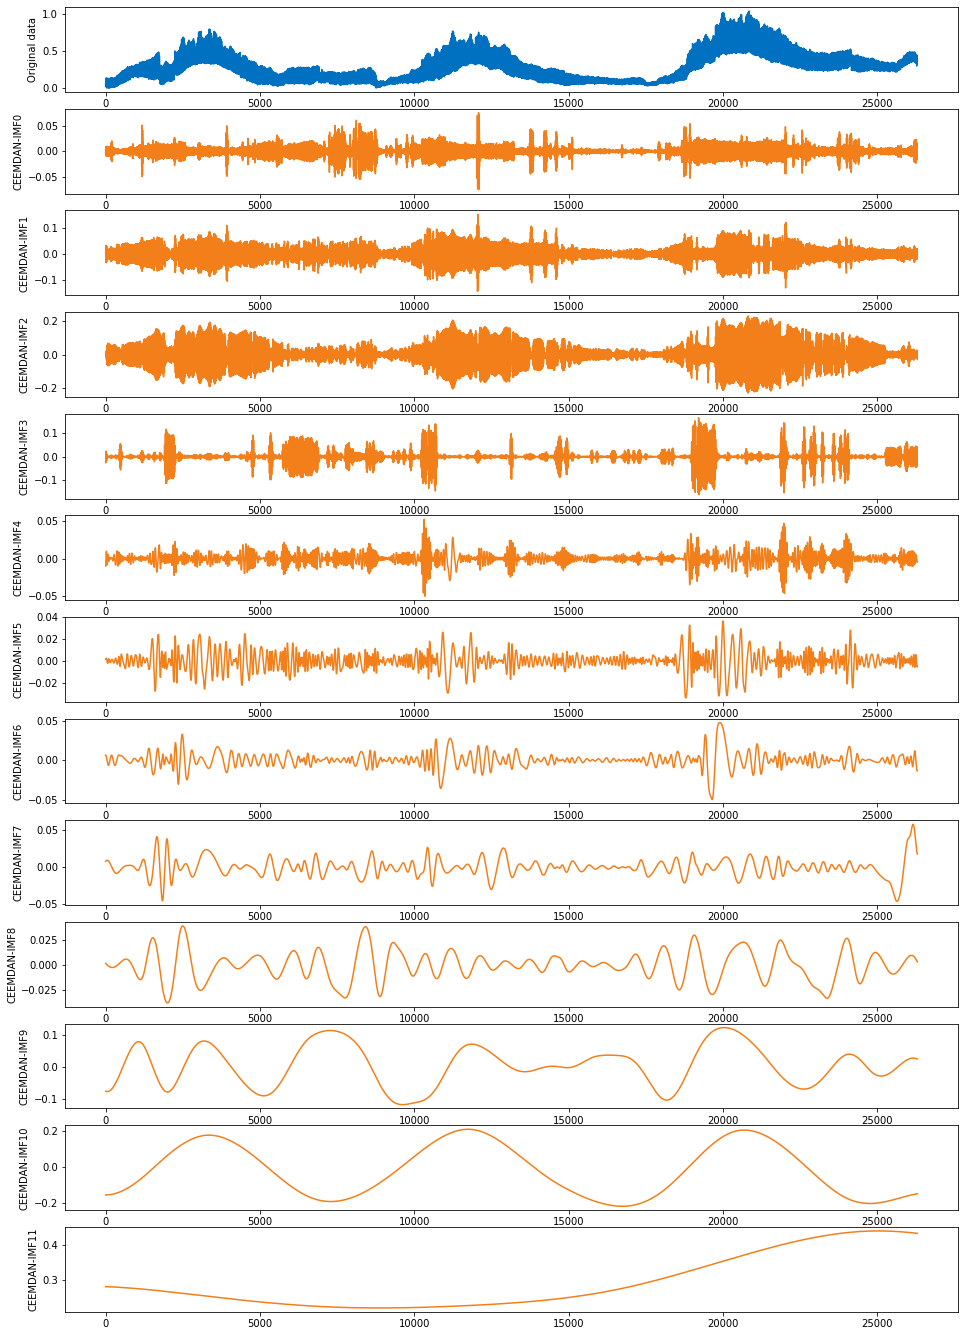

In [ ]:
####################plotting signals#####################
# Plot original data
series_index = range(len(reconstructed))
fig = plt.figure(figsize=(16,2*imfNo))
plt.subplot(1+imfNo, 1, 1 )
plt.plot(series_index, reconstructed, color='#0070C0') #F27F19 orange #0070C0 blue
plt.ylabel('Original data')
# Plot IMFs
for i in range(imfNo):
    plt.subplot(1 + imfNo,1,2 + i)
    plt.plot(series_index, imfs[i, :], color='#F27F19')
    plt.ylabel(str.upper('ceemdan')+'-IMF'+str(i))

In [ ]:
window = 24

x = []
y = []

index_i=0
for i in range(window, len(reconstructed)):
    x.append(reconstructed[i-window:i])
y = reconstructed[window:]
x, y = np.array(x), np.array(y)

In [ ]:
train_size=int(0.8*len(y))
validation_size=int(0.15*len(y))
test_size=int(0.05*len(y))

X_train = x[0:train_size]
X_valid = x[train_size:train_size+validation_size]
X_test = x[train_size+validation_size:]

y_train = y[0:train_size]
y_valid = y[train_size:train_size+validation_size]
y_test = y[train_size+validation_size:]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, xval, y_train, yval = train_test_split(x, y ,train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(xval, yval ,train_size=0.6)

In [ ]:
window = 365

train_size=int(0.8*len(reconstructed))
validation_size=int(0.15*len(reconstructed))
test_size=int(0.05*len(reconstructed))

training_set = reconstructed[0:train_size]
validation_set=reconstructed[train_size:train_size+validation_size]
test_set = reconstructed[train_size+validation_size:]

In [ ]:
X_train = []
y_train = []

index_i=0
for i in range(window, len(training_set)):
    X_train.append(training_set[i-window:i])
    y_train.append(training_set[i])
X_train, y_train = np.array(X_train), np.array(y_train)

X_valid = []
y_valid = []
for i in range(window, len(validation_set)):
    X_valid.append(validation_set[i-window:i])
    y_valid.append(validation_set[i])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_test = []
y_test = []
for i in range(window, len(test_set)):
    X_test.append(test_set[i-window:i])
    y_test.append(test_set[i])
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape


((21021, 24), (3941, 24), (1315, 24), (21021,), (3941,), (1315,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Reshape
from tensorflow.keras.initializers import random_uniform
from tensorflow.keras.layers import Flatten, Convolution1D, MaxPool1D, LSTM, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [ ]:

def model_GRU():
    n = 50
    model_1 = Sequential()
    model_1.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))
    #Adding the first LSTM layer and some Dropout regularisation
    model_1.add(GRU(units = n, return_sequences = True))
    model_1.add(Dropout(0.1))
    model_1.add(BatchNormalization())
    # Adding a second LSTM layer and some Dropout regularisation
    model_1.add(GRU(units = n, return_sequences = True))
    model_1.add(Dropout(0.1))
    model_1.add(BatchNormalization())
    # Adding a third LSTM layer and some Dropout regularisation
    model_1.add(GRU(units = n, return_sequences = True))
    model_1.add(Dropout(0.1))
    model_1.add(BatchNormalization())
    # Adding a fourth LSTM layer and some Dropout regularisation
    model_1.add(GRU(units = n))
    model_1.add(Dropout(0.1))
    # Adding the output layer
    model_1.add(Dense(units = 1))
    
    return model_1

In [ ]:
def model_1():
    n = 30
    model_1 = Sequential()
    model_1.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))
    #Adding the first LSTM layer and some Dropout regularisation
    model_1.add(LSTM(units = n, return_sequences = True))
    model_1.add(Dropout(0.1))
    # Adding a second LSTM layer and some Dropout regularisation
    model_1.add(LSTM(units = n, return_sequences = True))
    model_1.add(Dropout(0.1))
    # Adding a third LSTM layer and some Dropout regularisation
    model_1.add(LSTM(units = n, return_sequences = True))
    model_1.add(Dropout(0.1))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model_1.add(LSTM(units = n))
    model_1.add(Dropout(0.1))
    # Adding the output layer
    model_1.add(Dense(units = 1))
        
    return model_1

In [ ]:
import tensorflow as tf
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, min_lr=0.00001, verbose=1)
es = tf.keras.callbacks.EarlyStopping(patience=6)
callbacks_list = [rlrop, es]

In [ ]:
model = model_GRU()
model.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999), 
                    loss=tf.keras.losses.MeanSquaredError())

Epoch 1/6
42/42 [==============================] - 12s 59ms/step - loss: 0.5262
Epoch 2/6
42/42 [==============================] - 2s 58ms/step - loss: 0.5308
Epoch 3/6
42/42 [==============================] - 2s 59ms/step - loss: 0.4814
Epoch 4/6
42/42 [==============================] - 2s 59ms/step - loss: 0.1603
Epoch 5/6
42/42 [==============================] - 0s 9ms/step - loss: 0.7850


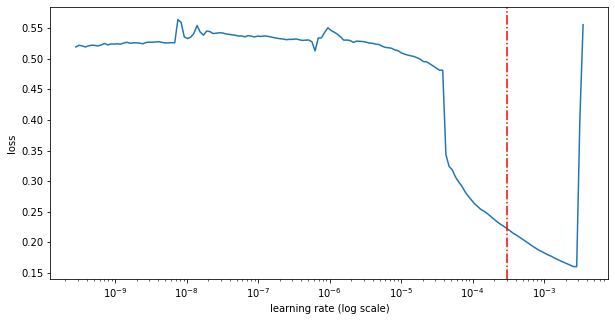

In [ ]:
bl = find_best_lr(X_train, y_train, model)

In [ ]:
print(bl)
model = model_GRU()
model.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999), 
                    loss=tf.keras.losses.MeanSquaredError())

0.00029839735


In [ ]:

history1=model.fit(X_train, y_train, 
                     epochs = 100, batch_size = 512,
                     validation_data=(X_valid, y_valid), callbacks=callbacks_list)

Epoch 1/100
42/42 [==============================] - 15s 101ms/step - loss: 0.3681 - val_loss: 0.0494 - lr: 0.0100
Epoch 2/100
42/42 [==============================] - 3s 61ms/step - loss: 0.0329 - val_loss: 0.0946 - lr: 0.0100
Epoch 3/100
42/42 [==============================] - 3s 61ms/step - loss: 0.0148 - val_loss: 0.0359 - lr: 0.0100
Epoch 4/100
42/42 [==============================] - 3s 61ms/step - loss: 0.0100 - val_loss: 0.0330 - lr: 0.0100
Epoch 5/100
42/42 [==============================] - 3s 61ms/step - loss: 0.0070 - val_loss: 0.0585 - lr: 0.0100
Epoch 6/100
42/42 [==============================] - 3s 61ms/step - loss: 0.0053 - val_loss: 0.0417 - lr: 0.0100
Epoch 7/100
41/42 [============================>.] - ETA: 0s - loss: 0.0043
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
42/42 [==============================] - 3s 61ms/step - loss: 0.0043 - val_loss: 0.0464 - lr: 0.0100
Epoch 8/100
42/42 [==============================] - 3s 61ms/ste

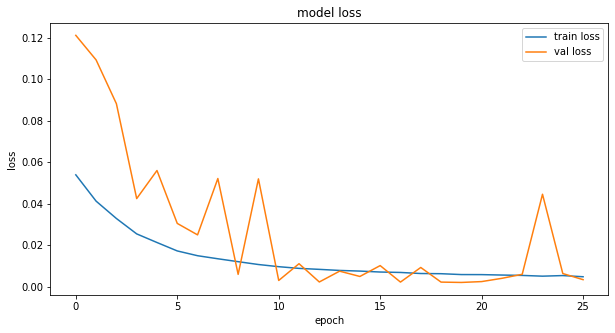

In [ ]:
# summarize history for loss
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(history1.history['loss'][2:])
plt.plot(history1.history['val_loss'][2:])
#plt.ylim(0.0, 1.0)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.show()

In [ ]:
pred_test=model.predict(X_test)


In [ ]:
def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
    
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
    
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
    
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
    
    return(b_0, b_1) 

def R_square(y,y_p):
    
    correlation_matrix = np.corrcoef(y, y_p)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    
    return r_squared

from math import sqrt
from sklearn.metrics import mean_squared_error
def RSME(y,y_p):
    rms = sqrt(mean_squared_error(y, y_p))
    
    return rms

from sklearn.metrics import mean_absolute_error

def MAE(y,y_p):
    mae = sqrt(mean_absolute_error(y, y_p))
    
    return mae

def SI(y,y_p):
    rms = sqrt(mean_squared_error(y, y_p))
    sum=0
    for i in y:
        sum=sum+sqrt(rms)/i
    
    return sum/len(y)

In [ ]:
#GRU
b = estimate_coef(y_test, pred_test) 
print("Estimated coefficients:\nb_0 = {} \nb_1 = {}".format(b[0], b[1])) 


print('R2:',R_square(y_test,pred_test.T))

print ('RSME:',RSME(y_test,pred_test))
print ('MAE:',MAE(y_test,pred_test))
print ('SI:',SI(y_test,pred_test))


Estimated coefficients:
b_0 = -9045.109933355765 
b_1 = 26956.008270474842
R2: 0.9637104727977545
RSME: 0.017422152399522217
MAE: 0.11452189941353445
SI: 0.4126554188828405


In [ ]:
#LSTM
b = estimate_coef(y_test, pred_test) 
print("Estimated coefficients:\nb_0 = {} \nb_1 = {}".format(b[0], b[1])) 

print('R2:',R_square(y_test,pred_test.T))
print ('RSME:',RSME(y_test,pred_test))
print ('MAE:',MAE(y_test,pred_test))
print ('SI:',SI(y_test,pred_test))

Estimated coefficients:
b_0 = -7497.000003243047 
b_1 = 22342.37014032656
R2: 0.8587218407961055
RSME: 0.05839760818628927
MAE: 0.2251499834588216
SI: 0.7554994948312752


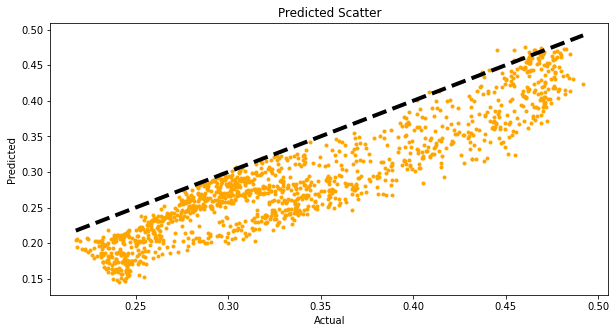

In [ ]:
plt.scatter(y_test, pred_test, color = "orange", marker = ".") 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
#plt.text(3.5, 12.7, r'$R^2$=$R2$', fontsize=20)

plt.xlabel('Actual') 
plt.ylabel('Predicted') 
plt.title('Predicted Scatter')
plt.show()

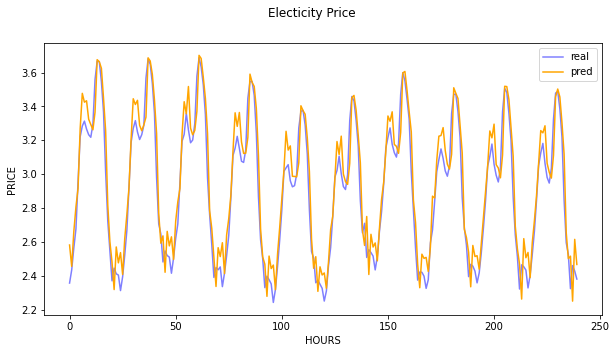

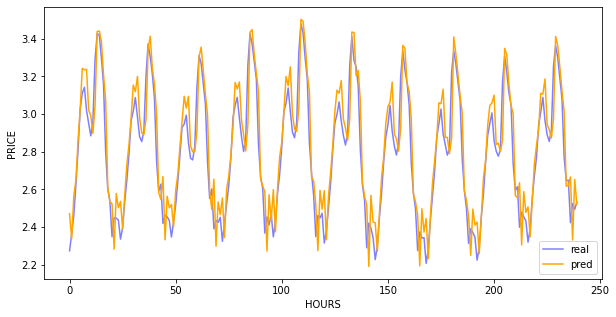

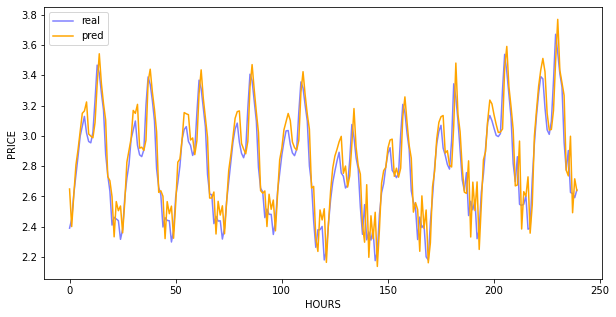

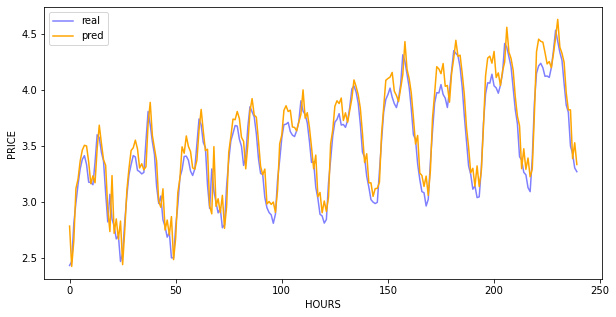

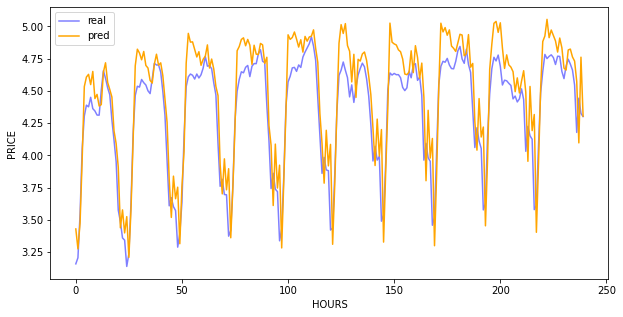

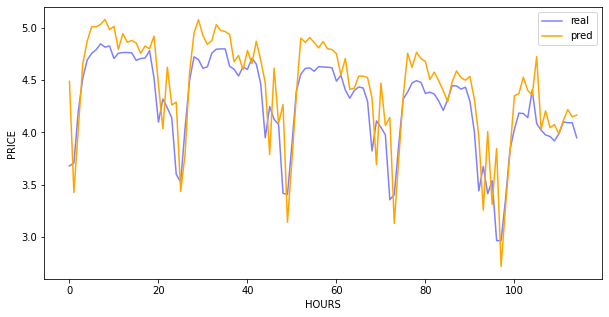

In [ ]:
l = 240
tl = len(y_test)

#fig, axs = plt.subplots(9, sharex=True, sharey=True)
plt.suptitle('Electicity Price ')

for i in range(len(y_test)//l+1):
  plt.plot(y_test[l*i:l*(1+i)]*10, '-', color = 'blue', label = 'real', alpha = 0.5)
  plt.plot(pred_test[l*i:l*(1+i)]*10, '-', color = 'orange', label = 'pred')
  plt.xlabel('HOURS')
  plt.ylabel('PRICE')
  plt.legend()
  plt.show()